In [1]:
import sys
import xarray as xr
import numpy as np
import pandas as pd
import math
import glob
import yaml
import geopandas
import cartopy
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar # different way to handle colorbar
import matplotlib.ticker as mticker
import cmocean.cm as cmo

# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature
import dask

# import personal modules
# Path to modules
sys.path.append('../modules')
# Import my modules
from utils import roundPartial, select_months_ds
from plotter import draw_basemap, plot_terrain
from colorline import colorline

dask.config.set(**{'array.slicing.split_large_chunks': True})

ERROR 1: PROJ: proj_create_from_database: Open of /home/dnash/miniconda3/envs/SEAK-clim/share/proj failed


In [2]:
server='skyriver'
if server == 'comet':
    path_to_data = '/data/projects/Comet/cwp140/'
elif server == 'expanse':
    path_to_data = '/expanse/lustre/scratch/dnash/temp_project/'
elif server == 'skyriver':
    path_to_data = '/home/dnash/comet_data/'
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [3]:
fname = path_to_data + 'preprocessed/ERA5_trajectories/final/PRISM_HUC8_14080107.nc'
final_ds = xr.open_dataset(fname)
final_ds

<xarray.Dataset>
Dimensions:       (start_date: 87, index: 72)
Coordinates:
    lat           (start_date, index) float64 ...
    lon           (start_date, index) float64 ...
    time          (start_date, index) datetime64[ns] ...
  * index         (index) int64 0 1 2 3 4 5 6 7 8 ... 63 64 65 66 67 68 69 70 71
  * start_date    (start_date) datetime64[ns] 2000-10-24 ... 2019-05-21
Data variables: (12/13)
    IVT           (start_date, index) float64 ...
    uIVT          (start_date, index) float64 ...
    vIVT          (start_date, index) float64 ...
    IWV           (start_date, index) float64 ...
    level         (start_date, index) float64 ...
    q             (start_date, index) float64 ...
    ...            ...
    v             (start_date, index) float64 ...
    w             (start_date, index) float64 ...
    dq            (start_date, index) float64 ...
    drying_ratio  (start_date, index) float64 ...
    ar_scale      (start_date) float64 ...
    ar            (start_date) float64 ...
Attributes:
    Conventions:                CF-1/0
    history:                    Fri Jul 17 11:51:01 2020: /apps/nco-4.9.3_gnu...
    history_of_appended_files:  Fri Jul 17 11:51:01 2020: Appended file ERA5_...
    NCO:                        netCDF Operators version 4.9.3 (Homepage = ht...

In [4]:
# select WY
NDJFMA = select_months_ds(final_ds, 11, 4)
MJJASO = select_months_ds(final_ds, 5, 10)
# JJA = final_ds.sel(start_date=final_ds.start_date.dt.season=="JJA")
# SON = final_ds.sel(start_date=final_ds.start_date.dt.season=="SON")
# ds_lst = [DJF, MAM, JJA, SON]
ds_lst = [NDJFMA, MJJASO]

In [5]:
min_ivt = final_ds.IVT.min().values
max_ivt = final_ds.IVT.max().values
print(np.round(min_ivt), np.round(max_ivt))

5.0 970.0


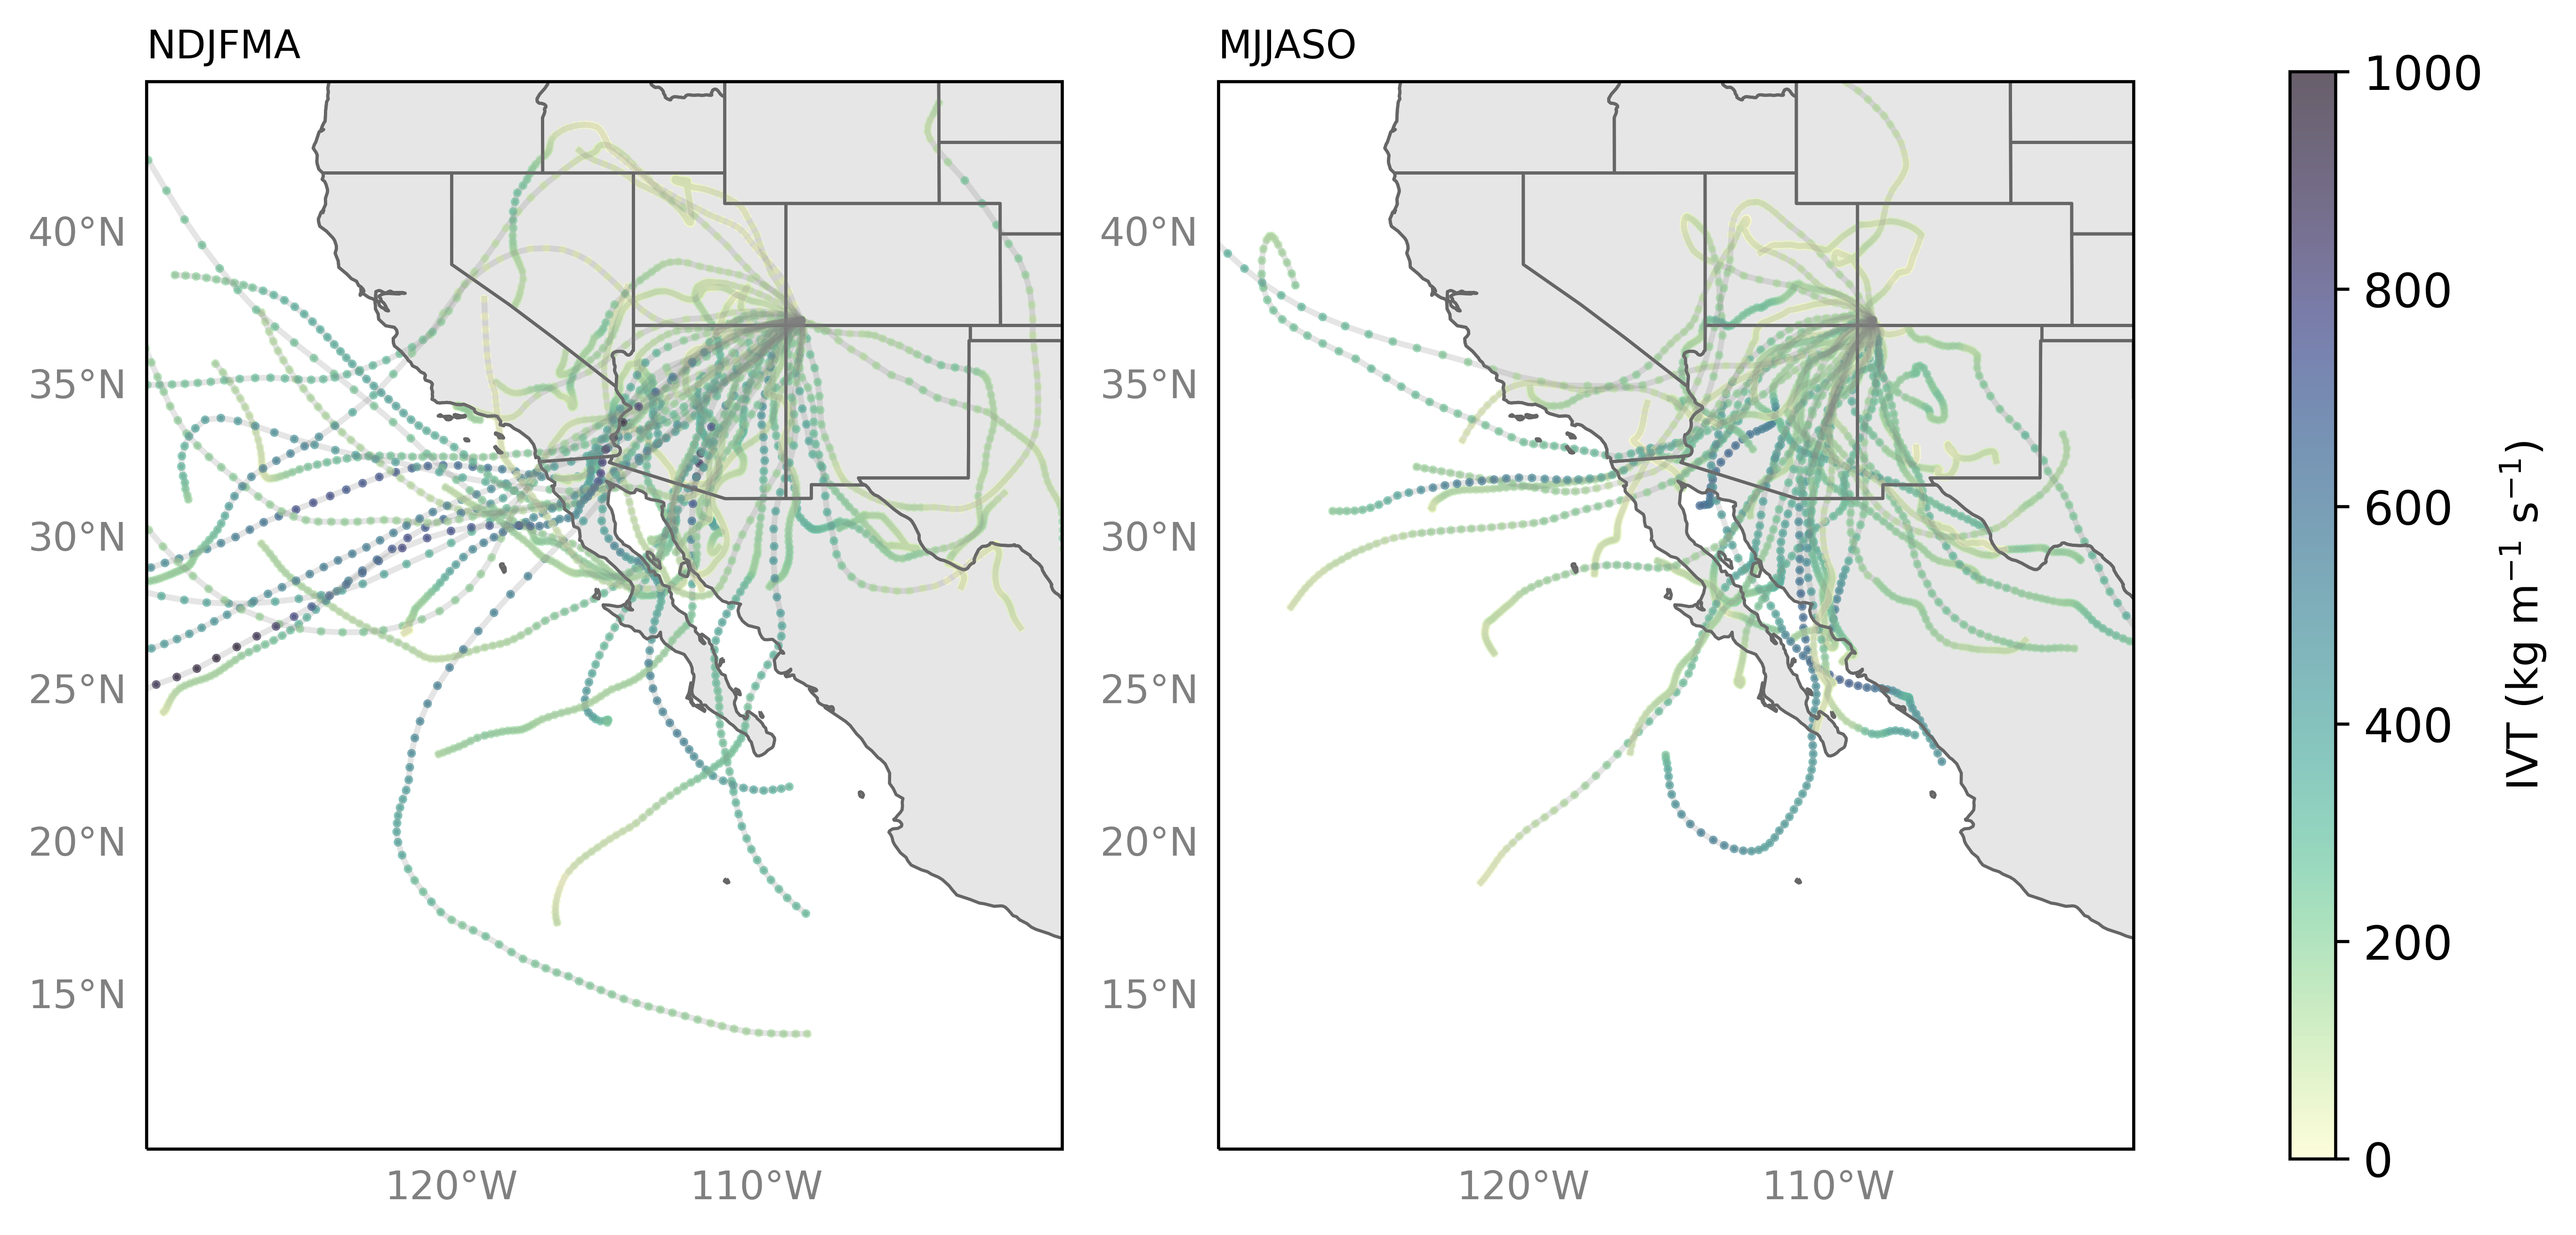

In [12]:
ext = [-130., -100., 10., 45.] 
fmt = 'png'

# Set up projection
datacrs = ccrs.PlateCarree()  ## the projection the data is in
mapcrs = ccrs.PlateCarree() ## the projection you want your map displayed in

# Set tick/grid locations
tx = 10
ty = 5
dx = np.arange(ext[0],ext[1]+tx,tx)
dy = np.arange(ext[2],ext[3]+ty,ty)

nrows = 1
ncols = 3

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1], width_ratios = [1, 1, 0.05], wspace=0.25, hspace=0.1)
## use gs[rows index, columns index] to access grids


fig = plt.figure(figsize=(10 ,5.0))
fig.dpi = 600
fname = path_to_figs + 'test_trajectory'

# enumerate through seasons
ssn = ['NDJFMA', 'MJJASO']
row_idx = [0, 0]
col_idx = [0, 1]
for k, ds in enumerate(ds_lst):
    ax = fig.add_subplot(gs[row_idx[k], col_idx[k]], projection=mapcrs)
    ax.set_title(ssn[k], loc='left', fontsize=10)
    ax = draw_basemap(ax, extent=ext, xticks=dx, yticks=dy,left_lats=True, right_lats=False)
    ax.set_extent(ext, datacrs)
    
    ax.add_feature(cfeature.STATES, edgecolor='0.4', linewidth=0.8)
    
    # need this to fix annotate transform
    transform = datacrs._as_mpl_transform(ax)
    nevents = len(ds.start_date)
    ## Add different points
    for i in range(nevents):
        data = ds.isel(start_date=i)
        y_lst = data.lat.values
        x_lst = data.lon.values
        z_lst = data.IVT.values
        ax.plot(x_lst, y_lst, c='gray', transform=datacrs, alpha=0.2)
        cf = ax.scatter(x_lst, y_lst, c=z_lst, vmin=0, vmax=1000, cmap=cmo.deep, marker='.', transform=datacrs, alpha=0.7, s=6)

# Add color bar
cbax = plt.subplot(gs[0,2]) # colorbar axis
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'vertical', ticklocation = 'right')
cb.set_label('IVT (kg m$^{-1}$ s$^{-1}$)', fontsize=11)
cb.ax.tick_params(labelsize=12)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi, transparent=True)
plt.show()
fig.clf()

In [24]:
AR0 = final_ds.where(final_ds.ar == 0, drop=True)
AR1 = final_ds.where(final_ds.ar == 1, drop=True)
# AR2 = final_ds.where(final_ds.ar_scale == 2, drop=True)
# AR3 = final_ds.where(final_ds.ar_scale == 3, drop=True)
# AR4 = final_ds.where(final_ds.ar_scale == 4, drop=True)
# AR5 = final_ds.where(final_ds.ar_scale == 5, drop=True)

# ds_lst = [AR0, AR1, AR2, AR3]
colors = ['grey', '#0ac1ff', '#04ff03', '#ffff03']

ds_lst = [AR0, AR1]
colors = ['grey', '#ff0100']

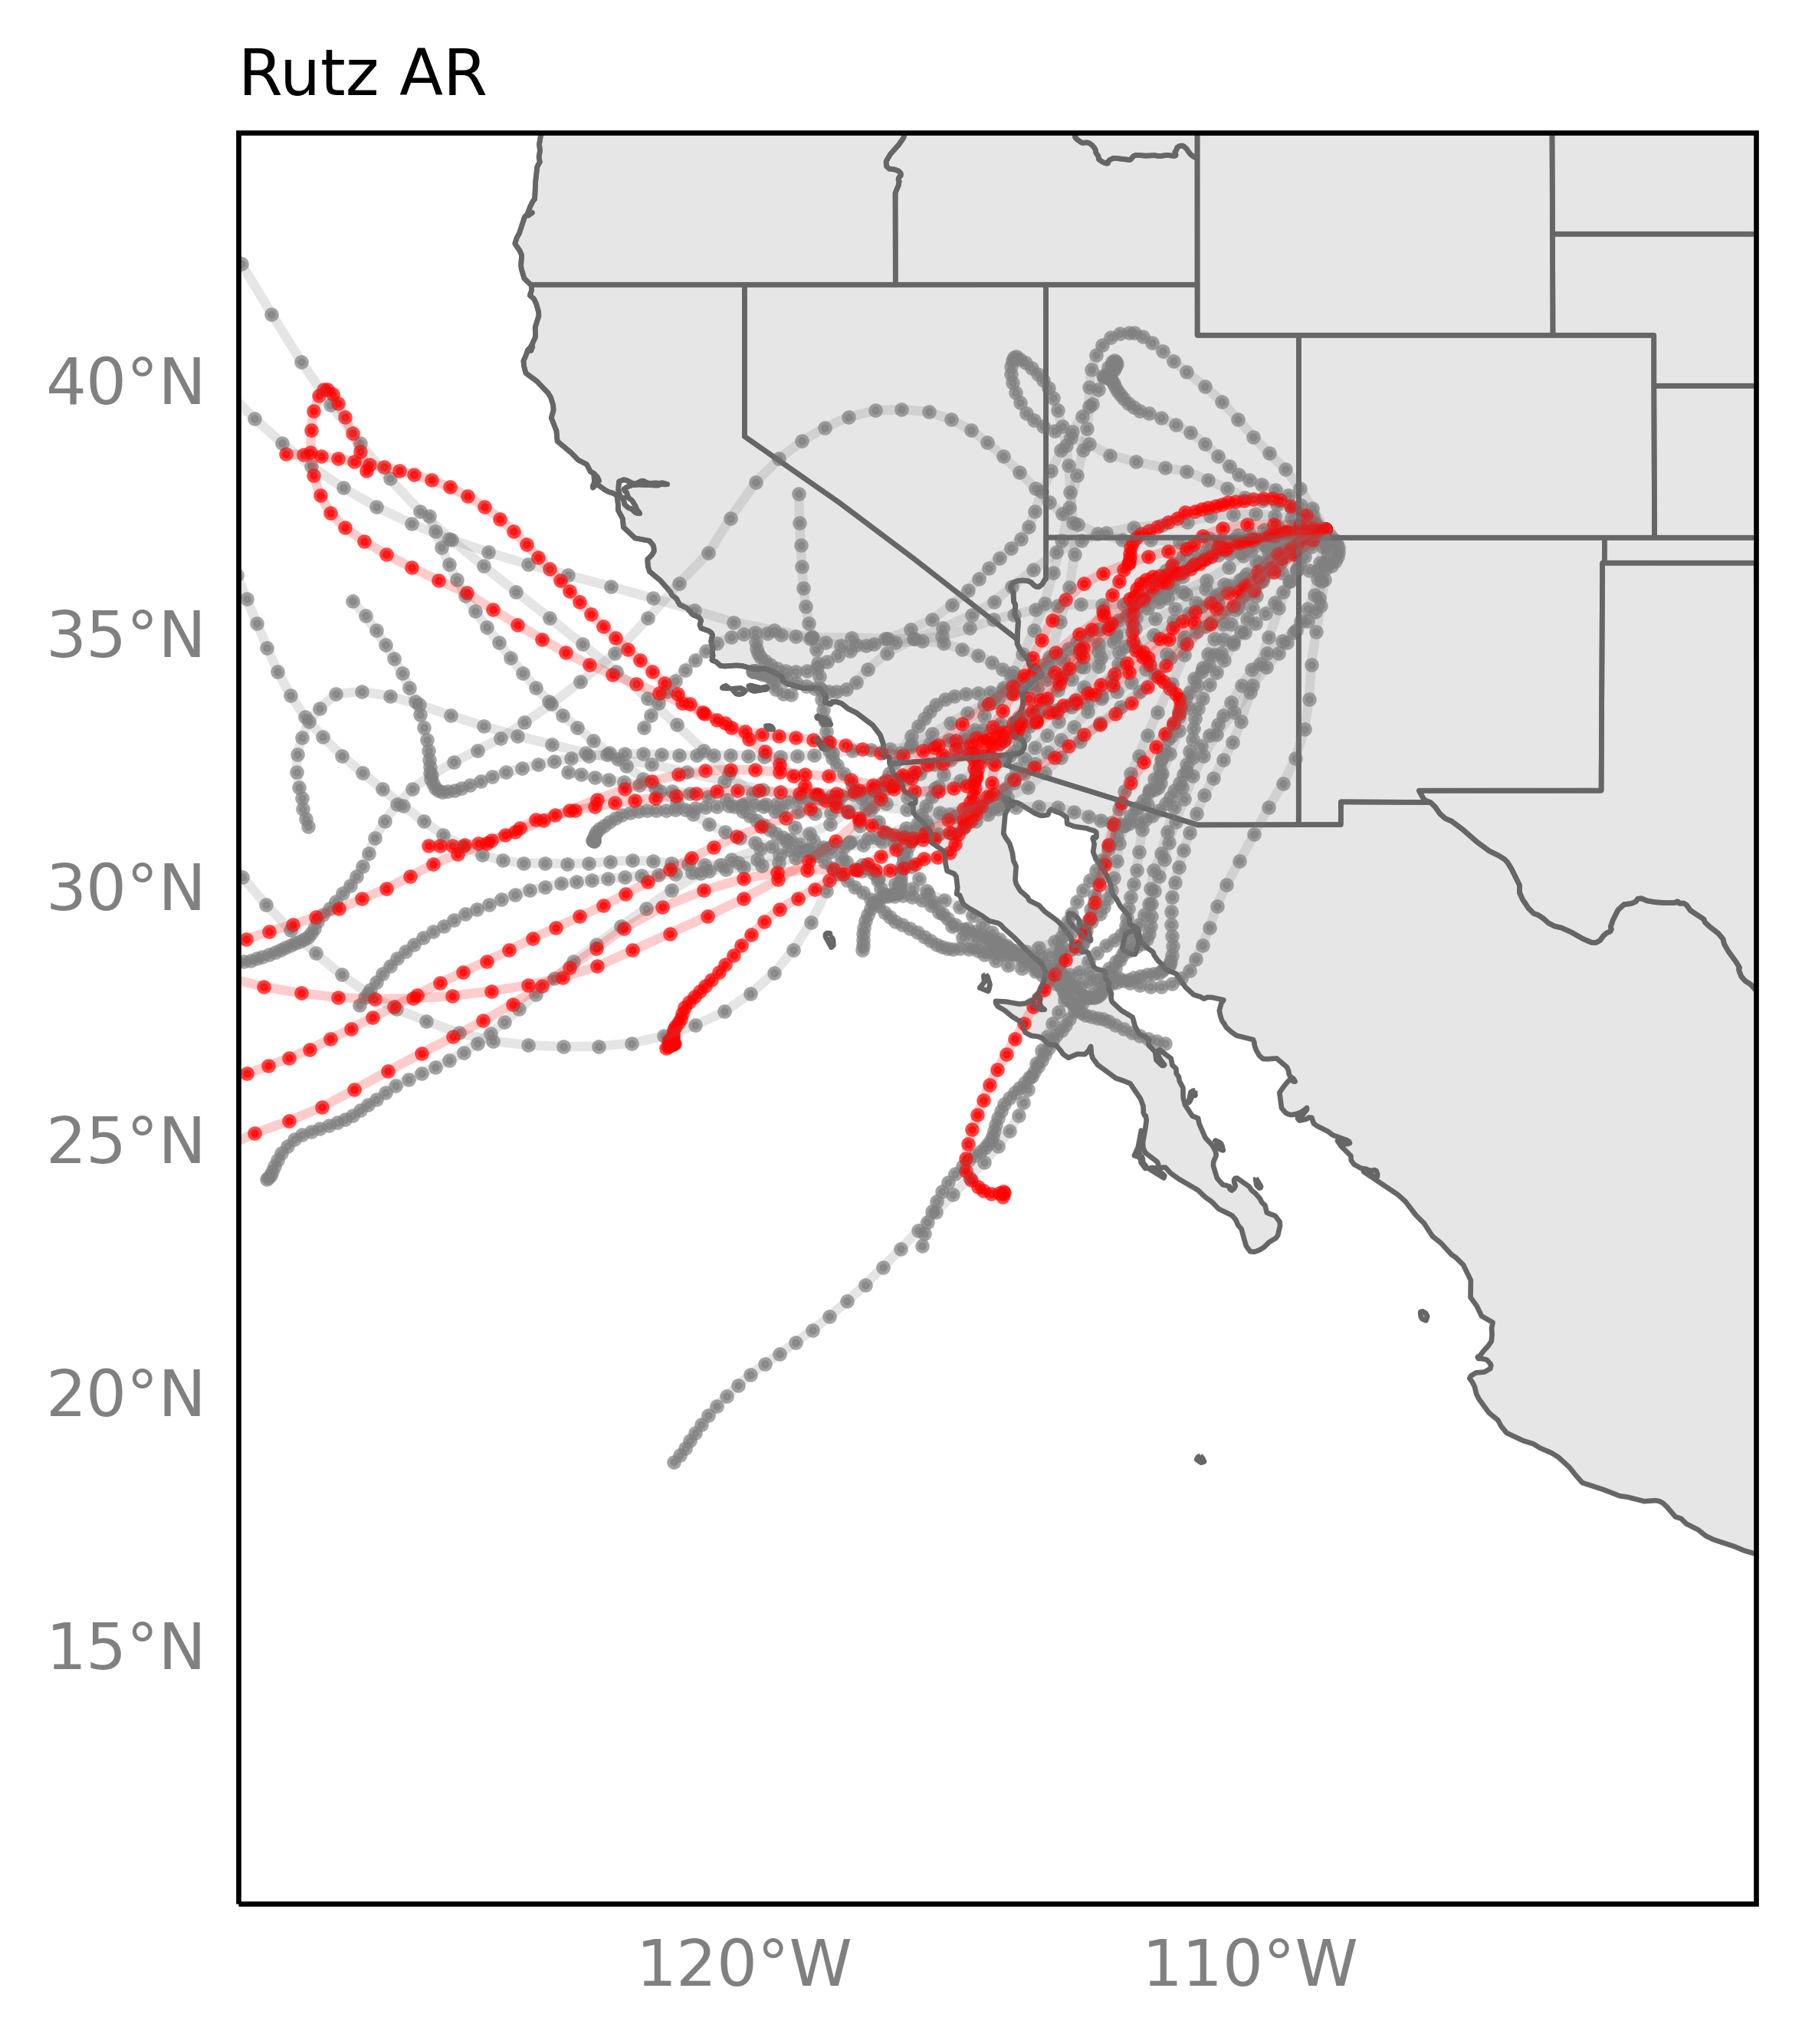

In [26]:
ext = [-130., -100., 10., 45.] 
fmt = 'png'

# Set up projection
datacrs = ccrs.PlateCarree()  ## the projection the data is in
mapcrs = ccrs.PlateCarree() ## the projection you want your map displayed in

# Set tick/grid locations
tx = 10
ty = 5
dx = np.arange(ext[0],ext[1]+tx,tx)
dy = np.arange(ext[2],ext[3]+ty,ty)

nrows = 1
ncols = 1

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1], width_ratios = [1], wspace=0.25, hspace=0.1)
## use gs[rows index, columns index] to access grids


fig = plt.figure(figsize=(10 ,5.0))
fig.dpi = 600
fname = path_to_figs + 'test_trajectory'


ax = fig.add_subplot(gs[0, 0], projection=mapcrs)
ax.set_title('Rutz AR', loc='left', fontsize=10)
ax = draw_basemap(ax, extent=ext, xticks=dx, yticks=dy,left_lats=True, right_lats=False)
ax.set_extent(ext, datacrs)

ax.add_feature(cfeature.STATES, edgecolor='0.4', linewidth=0.8)

# need this to fix annotate transform
transform = datacrs._as_mpl_transform(ax)
for k, ds in enumerate(ds_lst):
    nevents = len(ds.start_date)
    ## Add different points
    for i in range(nevents):
        data = ds.isel(start_date=i)
        y_lst = data.lat.values
        x_lst = data.lon.values
        ax.plot(x_lst, y_lst, c=colors[k], transform=datacrs, alpha=0.2)
        cf = ax.scatter(x_lst, y_lst, c=colors[k], marker='.', transform=datacrs, alpha=0.7, s=6)

# # Add color bar
# cbax = plt.subplot(gs[0,2]) # colorbar axis
# cb = Colorbar(ax = cbax, mappable = cf, orientation = 'vertical', ticklocation = 'right')
# cb.set_label('IVT (kg m$^{-1}$ s$^{-1}$)', fontsize=11)
# cb.ax.tick_params(labelsize=12)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi, transparent=True)
plt.show()
fig.clf()